# Binary Classification with a Bank Churn Dataset
## Playground Series - Season 4, Episode 1

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import optuna
from datetime import datetime as dt

# STATISTICS
from statsmodels.graphics.gofplots import qqplot

#notebook settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#category encoders
from category_encoders import BinaryEncoder

#sklearn libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, Binarizer, LabelEncoder, OneHotEncoder, TargetEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
# metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report,auc, accuracy_score
# imbalanced datasets
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import TomekLinks,RandomUnderSampler
# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel
# model selection
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
# pipelines
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.utils import class_weight

## READING FILES

**Bank Customer Churn Dataset**

The Bank Customer Churn Dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be customers. The dataset includes the following attributes:
- Customer ID: A unique identifier for each customer.
- Surname: The customer's surname or last name.
- Credit Score: A numerical value representing the customer's credit score.
- Geography: The country where the customer resides (France, Spain, or Germany).
- Gender: The customer's gender (Male or Female).
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank.
- Balance: The customer's account balance.
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card).
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no).
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no).
- EstimatedSalary: The estimated salary of the customer.
- Exited: Whether the customer has churned (1 = yes, 0 = no).

In [2]:
train_df = pd.read_csv('data/train.csv', index_col='id')
test_df = pd.read_csv('data/test.csv',index_col='id')
submission = pd.read_csv('data/sample_submission.csv')

## 1) EDA - Exploratory Data Analysis

### 1.1) Checking for missing values

In [3]:
train_df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [4]:
train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
test_df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [6]:
test_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


No missing Values in train and test data 😃✅

### 1.2) Checking for duplicated values

In [7]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())

0
0


No duplicated Values in train and test data 😃✅

### 1.3) Size of train and test data

In [8]:
print(train_df.shape)
print(test_df.shape)

(165034, 13)
(110023, 12)


### 1.4) Uniques values

In [9]:
# let's start looking at the training data
train_df.nunique()

CustomerId         23221
Surname             2797
CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

### 1.5) data type information

In [10]:
train_df.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

- **Customer ID**:
  - Treatment: Exclude from modeling or use it as an index, but do not include it as a feature in your predictive model.
  - Why: Customer ID is usually a unique identifier and does not contribute to the model's predictive power. Including it may lead to overfitting, as the
  model might mistakenly learn patterns specific to individual customers that do not generalize well.

- **Surname**:
  - Treatment: Exclude from modeling.
  - Why: Surnames are categorical data, but including them in a model might not provide meaningful information. If you attempt to one-hot encode surnames, it could lead to an extremely high-dimensional dataset, making the model computationally expensive and potentially overfit to the training data.

## 2) PreProcess Data

In [11]:
# build a transform function to drop columns with scikit-learn BaseEstimator and TransformerMixin.
# It will receive a list of columns to drop and return the transformed DataFrame without those columns.

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        return data.drop(labels=self.columns, axis='columns')

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in self.columns]


# let's test the DropColumns transformer
columns_to_drop = ['CustomerId', 'Surname']


# identifying categorical and numerical features
cat_ohe_features = ['Geography'] # order does not matter
cat_binary_features = ['Gender'] # converting to binary
cat_ord_features = ['NumOfProducts'] # order matters
num_features = ['CreditScore', 'Age','Tenure', 'Balance', 'EstimatedSalary']

# let's build a pipeline for cat features
cat_ohe_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

cat_ord_pipeline = Pipeline(steps=[
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

cat_binary_pipeline = Pipeline(steps=[
    ('binary', BinaryEncoder())
])

# let's build a pipeline for numerical features
num_pipeline = Pipeline(steps=[
    ('robust_scaler', RobustScaler())
])

# let's join the numerical and categorical pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat_ohe', cat_ohe_pipeline, cat_ohe_features),
    ('cat_binary', cat_binary_pipeline, cat_binary_features),
    ('cat_ord', cat_ord_pipeline, cat_ord_features),
    ('num', num_pipeline, num_features),
    ('pass', 'passthrough', ['HasCrCard', 'IsActiveMember'])
])

pipeline = Pipeline(steps=[
    ('drop_columns', DropColumns(columns=columns_to_drop)),
    ('preprocessor', preprocessor),
])


# let's test the pipeline on the training data
X_train = pipeline.fit_transform(train_df)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# create a dataframe with the transformed data and feature names
X_transformed = pd.DataFrame(X_train, columns=feature_names)

# check dataframe head
X_transformed.head()

,cat_ohe__Geography_France,cat_ohe__Geography_Germany,cat_ohe__Geography_Spain,cat_binary__Gender_0,cat_binary__Gender_1,cat_ord__NumOfProducts,num__CreditScore,num__Age,num__Tenure,num__Balance,num__EstimatedSalary,pass__HasCrCard,pass__IsActiveMember
0,1.0,0.0,0.0,0.0,1.0,1.0,0.079646,-0.4,-0.50,0.000000,0.788698,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,1.0,-0.283186,-0.4,-1.00,0.000000,-0.850085,1.0,1.0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.168142,0.3,1.25,0.000000,0.831134,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,-0.690265,-0.3,-0.75,1.241313,-0.414670,1.0,1.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.504425,-0.4,0.00,0.000000,-1.277766,1.0,1.0


In [12]:
# shapes
print('X_transformed shape: {}'.format(X_transformed.shape))
print('y shape: {}'.format(train_df['Exited'].shape))

X_transformed shape: (165034, 13)
y shape: (165034,)


In [13]:
# use xgboost as the model for our pipeline

params = {
    'objective': 'binary:logistic',
    'n_jobs': -1,
    'eval_metric': 'roc_auc'
}
    
model = xgb.XGBClassifier(params=params)
    

# let's create a pipeline with our previous pipeline (preprocessor) and the model
xgb_pipe = Pipeline(steps=[
    ('preprocessor', pipeline),
    ('xgboost', model)
])

# let's train our model
xgb_pipe.fit(train_df, train_df['Exited'])

# let's make predictions on the test set
predictions = xgb_pipe.predict_proba(test_df)[:, 1]


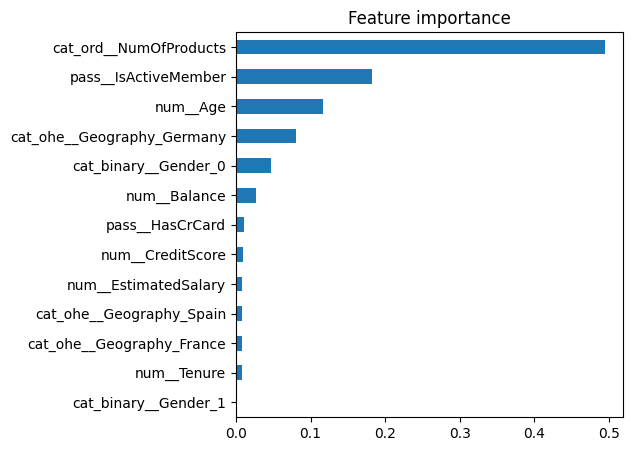

In [14]:
# let's create a function to plot the feature importance
def plot_feature_importance(model, X, y):
    plt.figure(figsize=(5, 5))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh')
    plt.title('Feature importance')
    plt.show()

plot_feature_importance(xgb_pipe.named_steps['xgboost'], X_transformed, train_df['Exited'])

In [15]:
# create a dataframe of feature importance values sorted by importance
feature_importance = pd.DataFrame({'feature': X_transformed.columns, 'importance': xgb_pipe.named_steps['xgboost'].feature_importances_}).sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
5,cat_ord__NumOfProducts,0.494919
12,pass__IsActiveMember,0.182950
7,num__Age,0.116714
1,cat_ohe__Geography_Germany,0.080283
3,cat_binary__Gender_0,0.047533
9,num__Balance,0.026731
11,pass__HasCrCard,0.011181
6,num__CreditScore,0.008776
10,num__EstimatedSalary,0.008363
2,cat_ohe__Geography_Spain,0.007611


In [16]:
X = train_df
y = train_df['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


def objective(trial):
    params = {
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 100.0),
    }

    model = xgb.XGBClassifier(**params)
    
    #use pipeline
    xgb_pipe = Pipeline(steps=[
        ('preprocessor', pipeline),
        ('xgboost', model)
    ])
    
    #fit model
    xgb_pipe.fit(X_train, y_train)
    
    #roc auc score
    predictions = xgb_pipe.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, predictions)
    
    return roc_auc

In [17]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-01-06 09:20:05,455] A new study created in memory with name: no-name-ed2eeedc-80f4-4fa7-9e5e-0751f85db0de
[I 2024-01-06 09:20:08,024] Trial 0 finished with value: 0.8835557994225562 and parameters: {'n_estimators': 526, 'learning_rate': 0.008456523809495483, 'max_depth': 4, 'subsample': 0.9554566983746375, 'colsample_bytree': 0.31615401968334345, 'min_child_weight': 13, 'gamma': 0.10250728412171994, 'scale_pos_weight': 16.482646256242006}. Best is trial 0 with value: 0.8835557994225562.
[I 2024-01-06 09:20:10,630] Trial 1 finished with value: 0.844090279872705 and parameters: {'n_estimators': 617, 'learning_rate': 0.0014730536000643394, 'max_depth': 2, 'subsample': 0.6910675336306283, 'colsample_bytree': 0.8591110293117188, 'min_child_weight': 3, 'gamma': 0.2797109748529101, 'scale_pos_weight': 35.246442934724776}. Best is trial 0 with value: 0.8835557994225562.
[I 2024-01-06 09:20:14,231] Trial 2 finished with value: 0.8609040918329243 and parameters: {'n_estimators': 947, 'le

Number of finished trials:  50
Best trial:
  Value: 0.8913259832157838
  Params: 
    n_estimators: 599
    learning_rate: 0.021888937480758056
    max_depth: 5
    subsample: 0.8601267166047363
    colsample_bytree: 0.5614251273925326
    min_child_weight: 15
    gamma: 0.5119500088279239
    scale_pos_weight: 15.040427239217717


In [18]:
params = trial.params

model_opt = xgb.XGBClassifier(**params)
    
# let's create a pipeline with our previous pipeline (preprocessor) and the model
xgb_opt = Pipeline(steps=[
    ('preprocessor', pipeline),
    ('xgboost', model_opt)
])

# let's train our model
xgb_opt.fit(train_df, train_df['Exited'])

# let's make predictions on the test set
predictions_optimized = xgb_opt.predict_proba(test_df)[:, 1]

In [19]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(estimator=xgb_pipe, 
                         X=train_df, 
                         y=train_df['Exited'], 
                         cv=cv,
                         scoring='roc_auc',
                         n_jobs=-1,
                         verbose=1)


scores_opt = cross_val_score(estimator=xgb_opt, 
                         X=train_df, 
                         y=train_df['Exited'], 
                         cv=cv,
                         scoring='roc_auc',
                         n_jobs=-1,
                         verbose=1)

# print scores and scores_opt
print('ROC AUC scores for the 10 folds: ', scores)
print('Mean ROC AUC score: %.3f' % scores.mean())

print('ROC AUC scores for the 10 folds: ', scores_opt)
print('Mean ROC AUC score: %.3f' % scores_opt.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


ROC AUC scores for the 10 folds:  [0.88942587 0.88541528 0.88847853 0.88537149 0.88457075 0.89307202
 0.88567355 0.88969507 0.88567    0.8826853 ]
Mean ROC AUC score: 0.887
ROC AUC scores for the 10 folds:  [0.89225227 0.88752546 0.8907082  0.88884435 0.88739779 0.89551771
 0.88856111 0.89377666 0.8884031  0.88632231]
Mean ROC AUC score: 0.890


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.1s finished


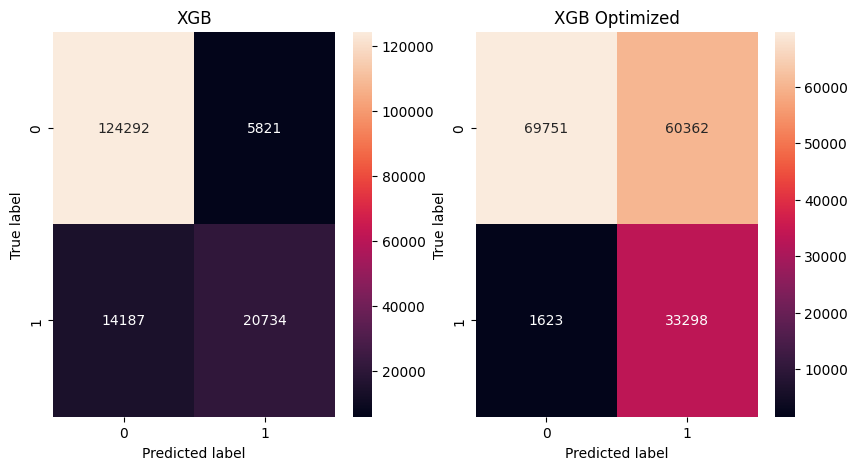

In [20]:
# plot confusion matrix for xgb and xgb_opt side by side with sns and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(confusion_matrix(train_df['Exited'], xgb_pipe.predict(train_df)), annot=True, fmt='d', ax=ax1)
sns.heatmap(confusion_matrix(train_df['Exited'], xgb_opt.predict(train_df)), annot=True, fmt='d', ax=ax2)
ax1.set_title('XGB')
ax2.set_title('XGB Optimized')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
plt.show()

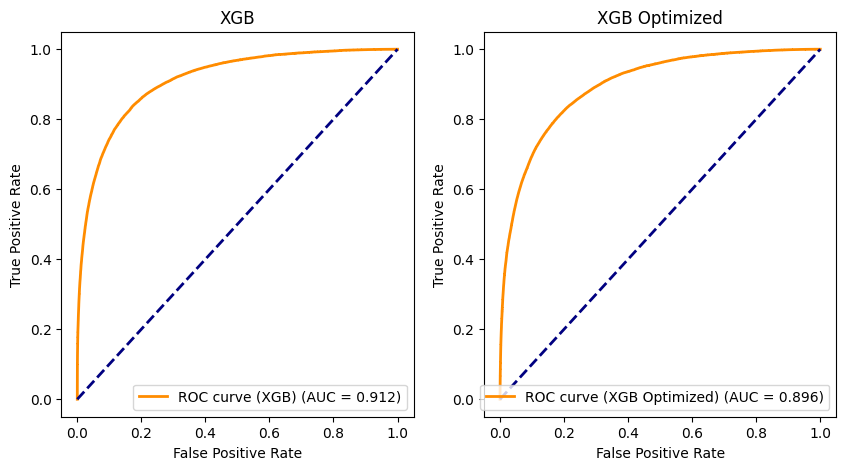

In [21]:
# plot roc curve for xgb and xgb_opt side by side with sns and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fpr_xgb, tpr_xgb, _ = roc_curve(train_df['Exited'], xgb_pipe.predict_proba(train_df)[:, 1])
fpr_xgb_opt, tpr_xgb_opt, _ = roc_curve(train_df['Exited'], xgb_opt.predict_proba(train_df)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_xgb_opt = auc(fpr_xgb_opt, tpr_xgb_opt)
ax1.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (XGB) (AUC = %0.3f)' % roc_auc_xgb)
ax2.plot(fpr_xgb_opt, tpr_xgb_opt, color='darkorange', lw=2, label='ROC curve (XGB Optimized) (AUC = %0.3f)' % roc_auc_xgb_opt)
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_title('XGB')
ax2.set_title('XGB Optimized')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right")
ax2.legend(loc="lower right")
plt.show()


[learning_curve] Training set sizes: [  1485  17823  34161  50500  66838  83176  99515 115853 132191 148530]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[learning_curve] Training set sizes: [  1485  17823  34161  50500  66838  83176  99515 115853 132191 148530]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


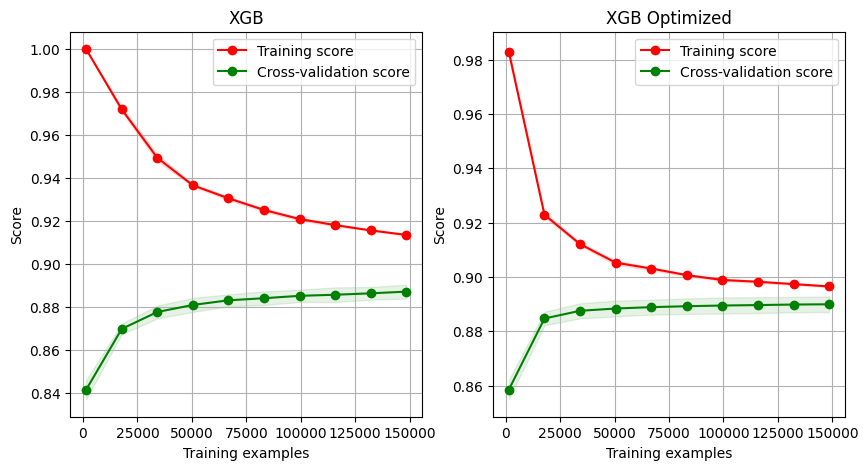

In [22]:
# plot learning curve for xgb and xgb_opt side by side with sns and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
train_sizes, train_scores, test_scores = learning_curve(xgb_pipe, train_df, train_df['Exited'], cv=cv, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10), verbose=1)
train_sizes_opt, train_scores_opt, test_scores_opt = learning_curve(xgb_opt, train_df, train_df['Exited'], cv=cv, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 10), verbose=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean_opt = np.mean(train_scores_opt, axis=1)
train_scores_std = np.std(train_scores, axis=1)
train_scores_std_opt = np.std(train_scores_opt, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_mean_opt = np.mean(test_scores_opt, axis=1)
test_scores_std = np.std(test_scores, axis=1)
test_scores_std_opt = np.std(test_scores_opt, axis=1)
ax1.grid()
ax2.grid()
ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
ax1.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
ax2.fill_between(train_sizes_opt, train_scores_mean_opt - train_scores_std_opt, train_scores_mean_opt + train_scores_std_opt, alpha=0.1, color='r')
ax2.fill_between(train_sizes_opt, test_scores_mean_opt - test_scores_std_opt, test_scores_mean_opt + test_scores_std_opt, alpha=0.1, color='g')
ax1.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
ax1.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
ax2.plot(train_sizes_opt, train_scores_mean_opt, 'o-', color='r', label='Training score')
ax2.plot(train_sizes_opt, test_scores_mean_opt, 'o-', color='g', label='Cross-validation score')
ax1.set_title('XGB')
ax2.set_title('XGB Optimized')
ax1.set_xlabel('Training examples')
ax1.set_ylabel('Score')
ax2.set_xlabel('Training examples')
ax2.set_ylabel('Score')
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.show()

## 3) Submission

In [23]:
# add to submission dataframe
submission['Exited'] = predictions_optimized

# save to csv
submission.to_csv('data/submission_7.csv', index=False)

# Best value for my model was: 0.88628 - submission 7